In [1]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Fs = 1000 # Sampling frequency of all measurements

c shared library imported successfully!
Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [2]:
'''
General Functions
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

''' Additional Computation for the whole pouch based on pouch structure'''
# def addComputation(DFdata, pouchStructure): # (Obsolete)
#     rectNum = np.sum(pouchStructure +1) # Number of rectangle pouch-cell <- np.sum(pouchStructure - 1)
#     triNum = rectNum*2 - len(pouchStructure) -3 # Number of triangle pouch-cell <- rectNum*2 - len(pouchStructure) +1
#     print("Pouch contains totally %d rectangle and %d triangle" % (rectNum, triNum))

#     DFdata['totalVol'] = (triNum * DFdata['triVol'] + rectNum * DFdata['rectVol']) # (mm3) Total volume of the entire pouch
#     DFdata['totalLength'] = (DFdata['dashSpace'] + DFdata['dashLength']) * len(pouchStructure) - DFdata['dashSpace'] # (mm) Total length of the entire pouch
#     DFdata['totalWidth'] = DFdata['dashHalfDist'] * 2 * (np.amax(pouchStructure) + 1) # (mm) Total width of the entire pouch

#     DFdata['triArea'] = DFdata['dashSpace'] * DFdata['dashHalfDist'] # (mm2) Top-view area of a triangle pouch (Not surface area)
#     DFdata['rectArea'] = 2 * DFdata['dashHalfDist'] * DFdata['dashLength'] # (mm2) Top-view area of a rectangle pouch (Not surface area)

#     DFdata['totalCapa'] = (triNum * DFdata['triCapa'] + rectNum * DFdata['rectCapa']) # (Farad)
    
#     return DFdata, rectNum, triNum

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure):           
    filtData = lowpassFilter(rawData, 5, Fs, 8) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure


In [3]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'16C?',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'16C?',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'16C?',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'16C?',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',       'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',       'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',       'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',        'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube']
]
condiTable = pd.DataFrame(condiTable, columns = colNames)
# condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
# materialProperty.to_csv("MaterialProperty.csv", index=False)

In [ ]:
''' Design and zipping state '''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
#stateLayout.to_csv("StateLayout.csv", index=False)


In [ ]:
''' Generate model by matched parameters after getting model data of Valid Arc Length '''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

#md.to_csv("ValidArcLength.csv", index=False)
md.head(1)    

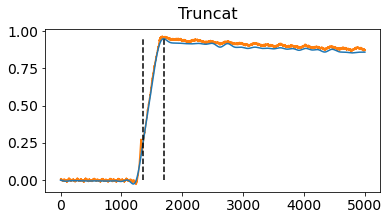


6mLBOPP12 - Trial06
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.042 (bar) in 0.343 (sec)



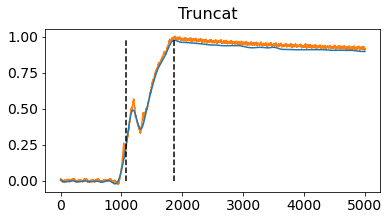


6mLBOPP12 - Trial07
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.044 (bar) in 0.796 (sec)



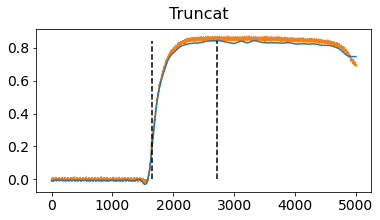


6mLBOPP12 - Trial08
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.037 (bar) in 1.070 (sec)



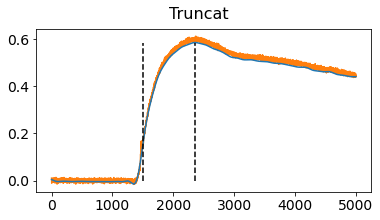


6mLBOPP12 - Trial11
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.024 (bar) in 0.861 (sec)



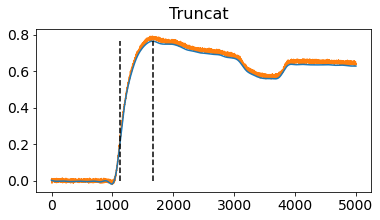


6mLBOPP12 - Trial12
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.033 (bar) in 0.539 (sec)



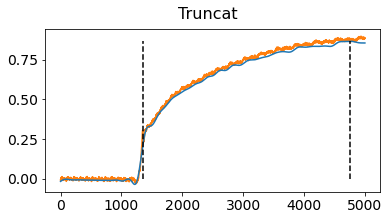


6mLBOPP16 - Trial04
Avg. Pressure of zipping = 0.029 (bar), Max. P. = 0.039 (bar) in 3.402 (sec)



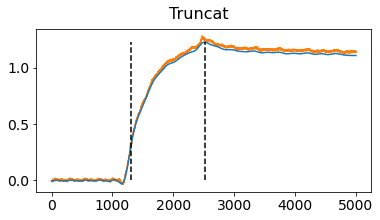


6mLBOPP16 - Trial05
Avg. Pressure of zipping = 0.042 (bar), Max. P. = 0.058 (bar) in 1.208 (sec)



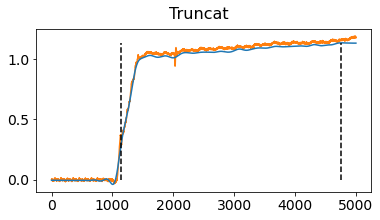


6mLBOPP16 - Trial06
Avg. Pressure of zipping = 0.047 (bar), Max. P. = 0.053 (bar) in 3.619 (sec)



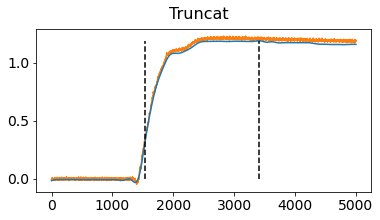


6mLBOPP16 - Trial07
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.055 (bar) in 1.876 (sec)



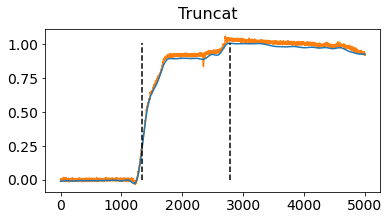


6mLBOPP16 - Trial08
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.047 (bar) in 1.433 (sec)



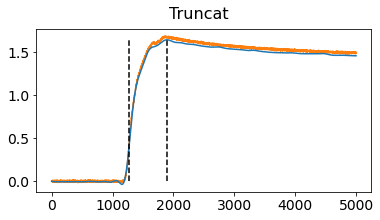


BOPP16ShiftedU7kV - Trial01
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.078 (bar) in 0.621 (sec)



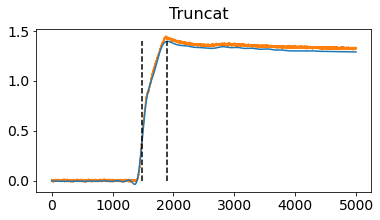


BOPP16ShiftedU7kV - Trial02
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.066 (bar) in 0.423 (sec)



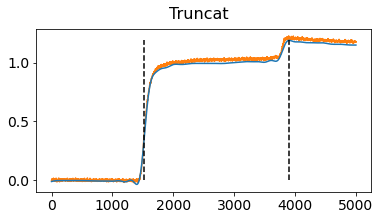


BOPP16ShiftedU7kV - Trial03
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.055 (bar) in 2.391 (sec)



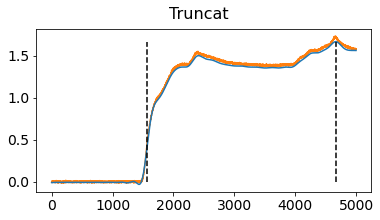


BOPP16ShiftedU7kV - Trial04
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.080 (bar) in 3.098 (sec)



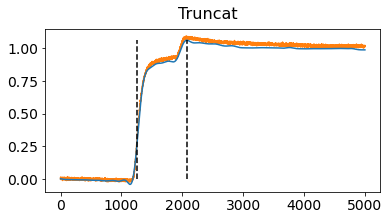


BOPP16ShiftedU7kV - Trial05
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.048 (bar) in 0.819 (sec)



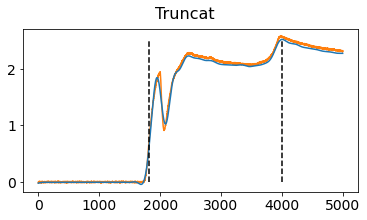


L0Ws16ShiftedU9kV - Trial01
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.122 (bar) in 2.186 (sec)



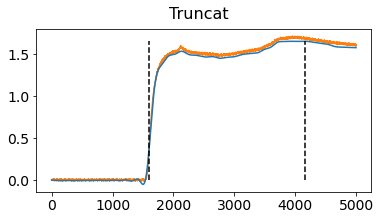


L0Ws16ShiftedU9kV - Trial02
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.079 (bar) in 2.547 (sec)



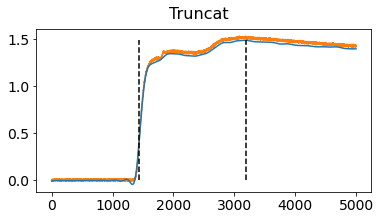


L0Ws16ShiftedU9kV - Trial03
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.070 (bar) in 1.754 (sec)



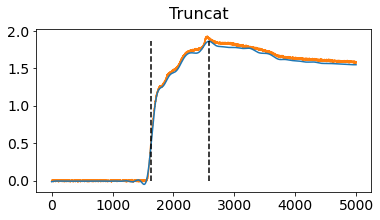


L0Ws16ShiftedU9kV - Trial04
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.090 (bar) in 0.953 (sec)



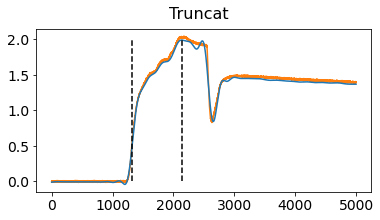


L0Ws16ShiftedU9kV - Trial05
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.096 (bar) in 0.814 (sec)



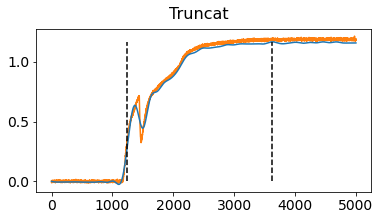


L0Ws16NoShift - Trial01
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.054 (bar) in 2.382 (sec)



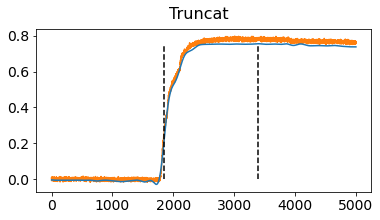


L0Ws16NoShift - Trial02
Avg. Pressure of zipping = 0.030 (bar), Max. P. = 0.034 (bar) in 1.548 (sec)



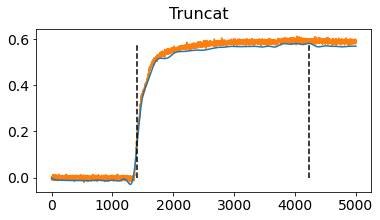


L0Ws16NoShift - Trial03
Avg. Pressure of zipping = 0.022 (bar), Max. P. = 0.024 (bar) in 2.819 (sec)



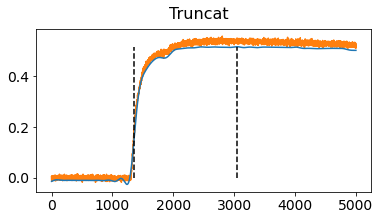


L0Ws16NoShift - Trial04
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.022 (bar) in 1.698 (sec)



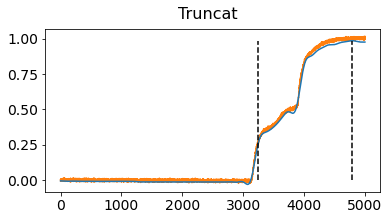


L0Ws16NoShift - Trial05
Avg. Pressure of zipping = 0.030 (bar), Max. P. = 0.045 (bar) in 1.551 (sec)



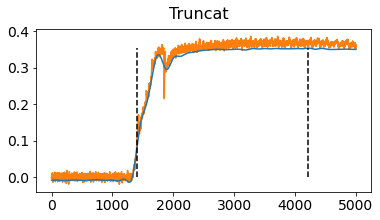


6mLL0Ws12SoftTube - Trial06
Avg. Pressure of zipping = 0.011 (bar), Max. P. = 0.013 (bar) in 2.809 (sec)



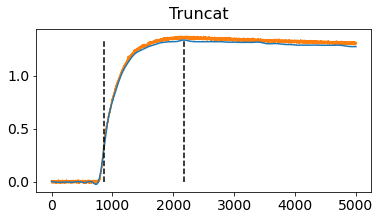


6mLL0Ws12SoftTube - Trial07
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.062 (bar) in 1.309 (sec)



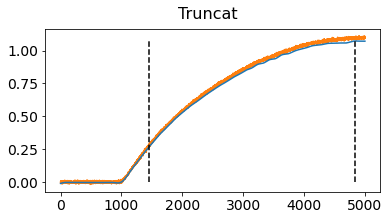


6mLL0Ws12SoftTube - Trial08
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.049 (bar) in 3.388 (sec)



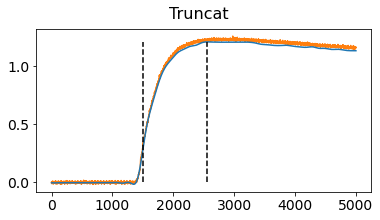


6mLL0Ws12SoftTube - Trial09
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.056 (bar) in 1.054 (sec)



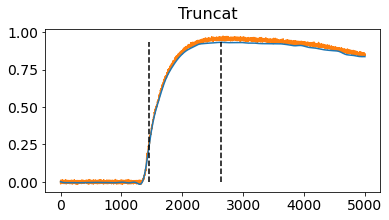


6mLL0Ws12SoftTube - Trial10
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.042 (bar) in 1.179 (sec)



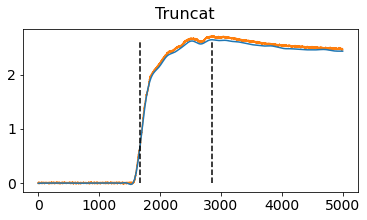


Mylar16 - Trial01
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.129 (bar) in 1.182 (sec)



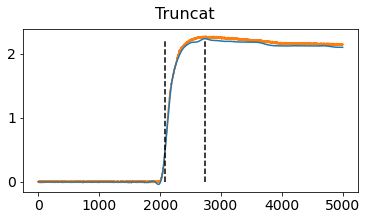


Mylar16 - Trial02
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.107 (bar) in 0.649 (sec)



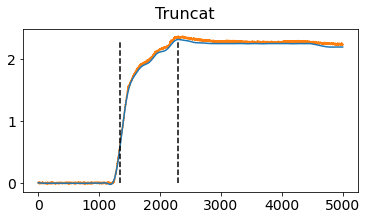


Mylar16 - Trial03
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.112 (bar) in 0.960 (sec)



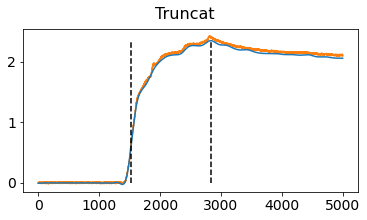


Mylar16 - Trial04
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.114 (bar) in 1.313 (sec)



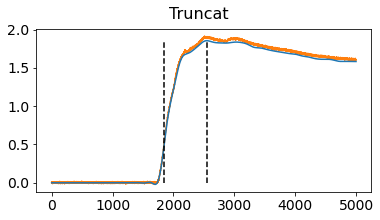


Mylar16 - Trial05
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.089 (bar) in 0.705 (sec)



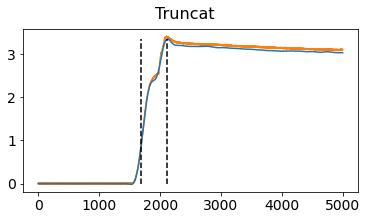


Mylar16NoShift - Trial01
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.164 (bar) in 0.435 (sec)



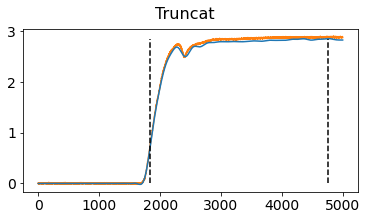


Mylar16NoShift - Trial02
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.138 (bar) in 2.929 (sec)



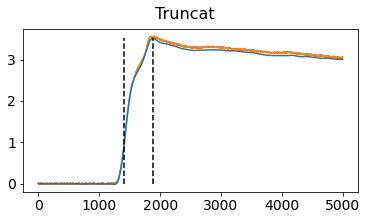


Mylar16NoShift - Trial03
Avg. Pressure of zipping = 0.127 (bar), Max. P. = 0.171 (bar) in 0.480 (sec)



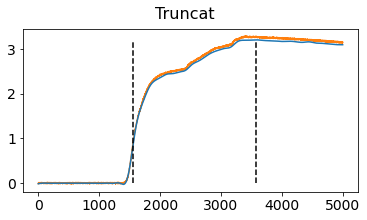


Mylar16NoShift - Trial04
Avg. Pressure of zipping = 0.127 (bar), Max. P. = 0.158 (bar) in 2.023 (sec)



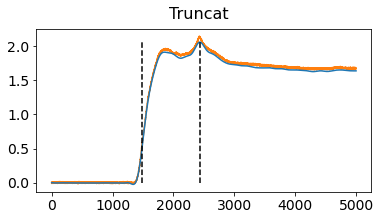


Mylar16NoShift - Trial05
Avg. Pressure of zipping = 0.082 (bar), Max. P. = 0.101 (bar) in 0.948 (sec)



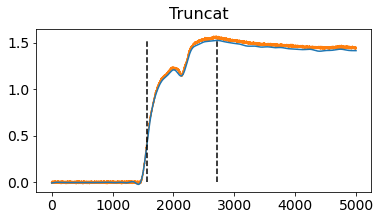


BOPP16 - Trial01
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.072 (bar) in 1.157 (sec)



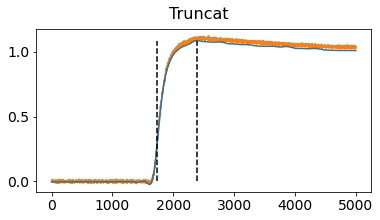


BOPP16 - Trial02
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.050 (bar) in 0.657 (sec)



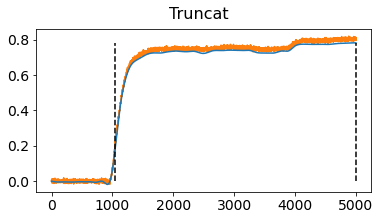


BOPP16 - Trial03
Avg. Pressure of zipping = 0.031 (bar), Max. P. = 0.035 (bar) in 3.950 (sec)



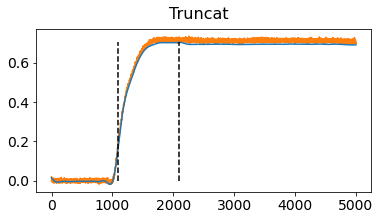


BOPP16 - Trial04
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.031 (bar) in 1.000 (sec)



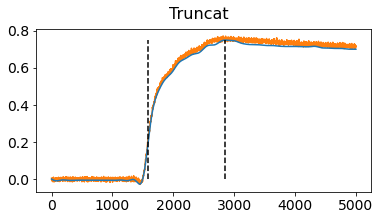


BOPP16 - Trial05
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.032 (bar) in 1.270 (sec)



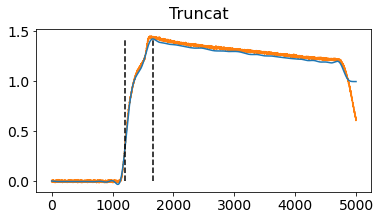


BOPP20 - Trial01
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.066 (bar) in 0.452 (sec)



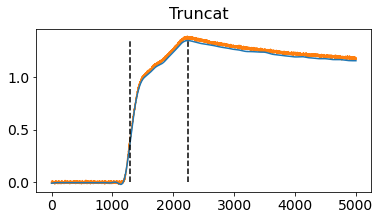


BOPP20 - Trial02
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.063 (bar) in 0.957 (sec)



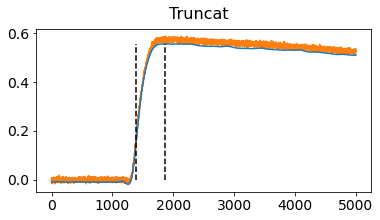


BOPP20 - Trial03
Avg. Pressure of zipping = 0.017 (bar), Max. P. = 0.023 (bar) in 0.473 (sec)



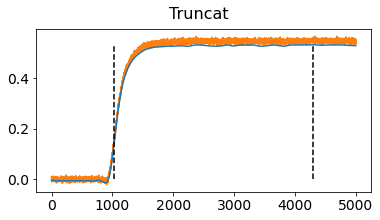


BOPP20 - Trial04
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.022 (bar) in 3.275 (sec)



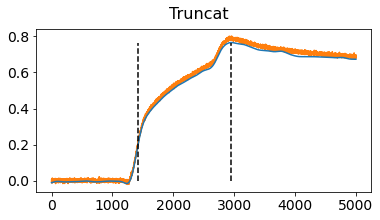


BOPP20 - Trial05
Avg. Pressure of zipping = 0.022 (bar), Max. P. = 0.034 (bar) in 1.537 (sec)



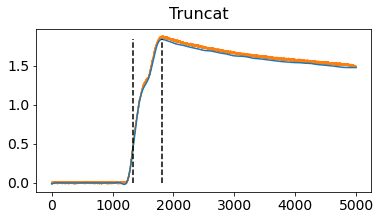


BOPP16U9kV - Trial01
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.087 (bar) in 0.474 (sec)



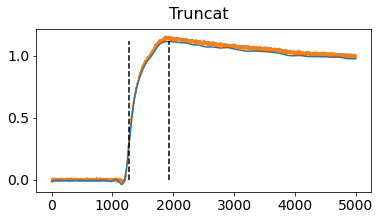


BOPP16U9kV - Trial02
Avg. Pressure of zipping = 0.040 (bar), Max. P. = 0.052 (bar) in 0.649 (sec)



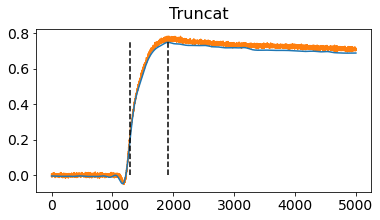


BOPP16U9kV - Trial03
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.033 (bar) in 0.626 (sec)



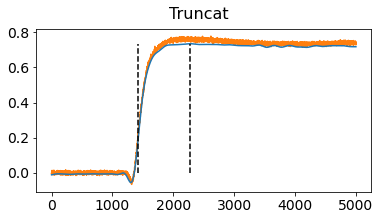


BOPP16U9kV - Trial04
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.033 (bar) in 0.854 (sec)



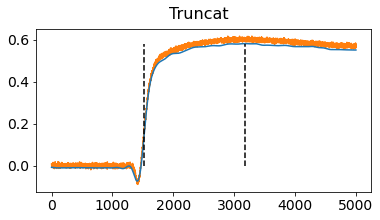


BOPP16U9kV - Trial05
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.025 (bar) in 1.648 (sec)



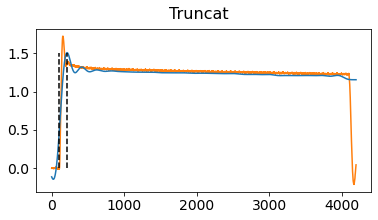


MLSi16SB7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.080 (bar) in 0.115 (sec)



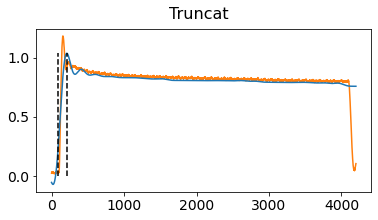


MLSi16SB7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.053 (bar) in 0.117 (sec)



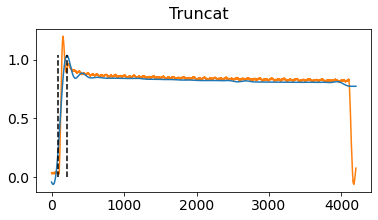


MLSi16SB7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.054 (bar) in 0.118 (sec)



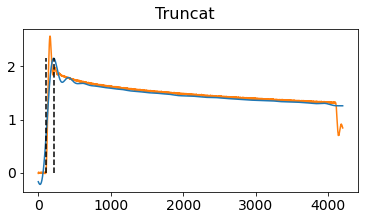


MLSi16SB7kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.122 (bar) in 0.112 (sec)



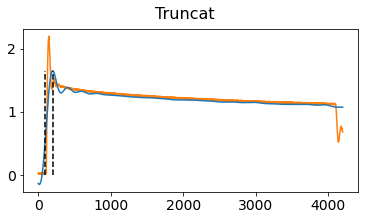


MLSi16SB7kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.103 (bar) in 0.111 (sec)



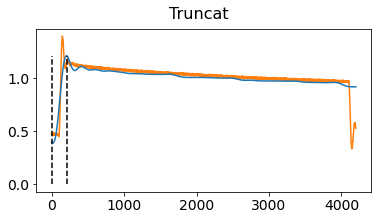


MLSi16SB7kV - Trial05 - Seg3
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.063 (bar) in 0.207 (sec)



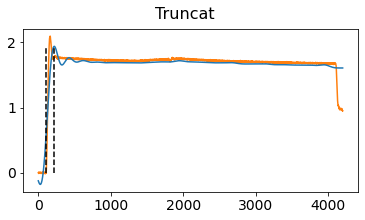


MLSi16CB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.098 (bar) in 0.117 (sec)



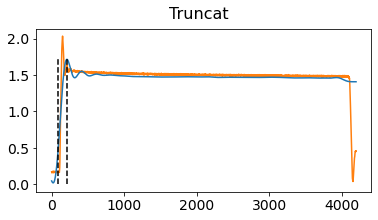


MLSi16CB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.095 (bar) in 0.124 (sec)



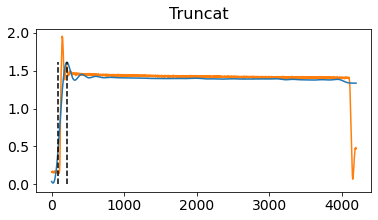


MLSi16CB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.091 (bar) in 0.125 (sec)



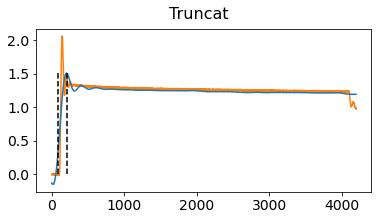


MLSi16CB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.096 (bar) in 0.113 (sec)



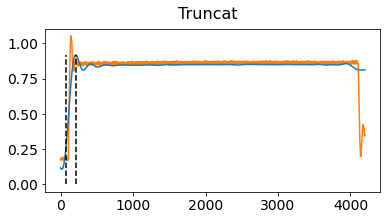


MLSi16CB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.046 (bar) in 0.140 (sec)



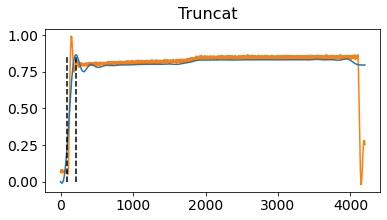


MLSi16CB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.043 (bar) in 0.124 (sec)



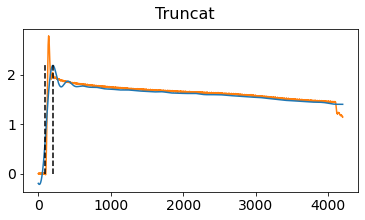


MLSi20SB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.133 (bar) in 0.112 (sec)



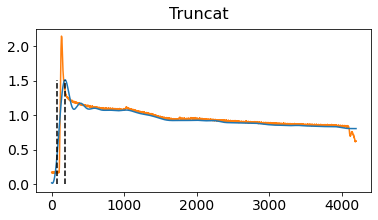


MLSi20SB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.050 (bar), Max. P. = 0.101 (bar) in 0.114 (sec)



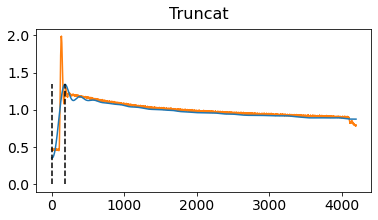


MLSi20SB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.093 (bar) in 0.184 (sec)



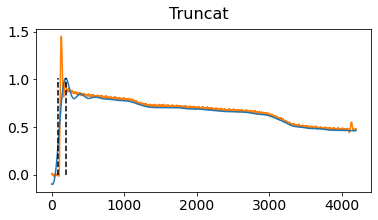


MLSi20SB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.066 (bar) in 0.110 (sec)



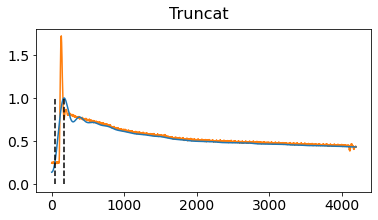


MLSi20SB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.030 (bar), Max. P. = 0.080 (bar) in 0.128 (sec)



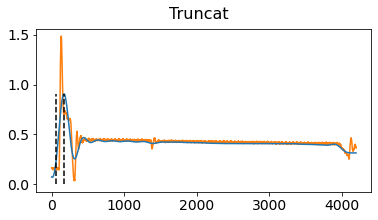


MLSi20SB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.068 (bar) in 0.110 (sec)



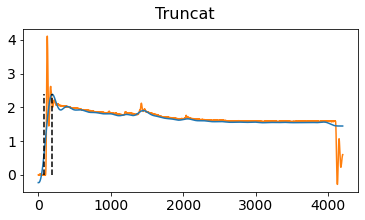


MLSi20B7kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.199 (bar) in 0.114 (sec)



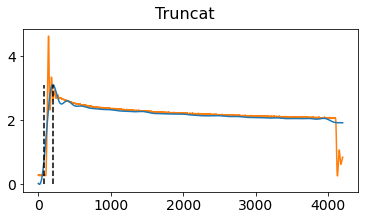


MLSi20B7kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.224 (bar) in 0.120 (sec)



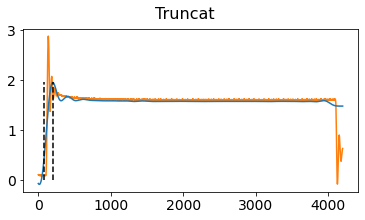


MLSi20B7kV - Trial03 - Seg3
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.137 (bar) in 0.116 (sec)



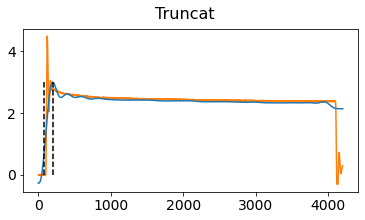


MLSi20B7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.107 (bar), Max. P. = 0.218 (bar) in 0.117 (sec)



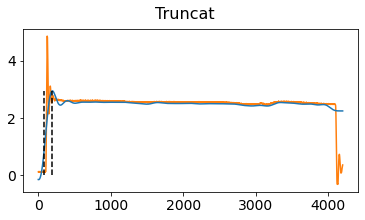


MLSi20B7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.236 (bar) in 0.118 (sec)



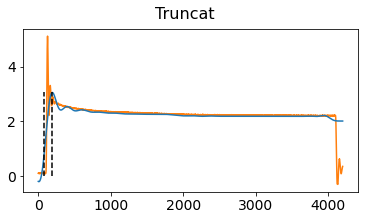


MLSi20B7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.249 (bar) in 0.114 (sec)



In [4]:
''' Process measurement data saved as individual csv files by trial '''
dataPath = ".\data\ValidData"

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
dataPath2 = ".\data\TrekData"
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)

pressData = []
for root, directories, files in walk(dataPath):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi = re.split('_|\.csv', fileName)[3:5]

            names = condi[0]         
            trialNum = int(re.split('t', condi[1])[-1])

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')

            inactivePressure = np.mean(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure = processPressure(data, Fs, inactivePressure)
            avgPressure = (avgPressure - calib[1]) * calib[0]
            maxPressure = (maxPressure - calib[1]) * calib[0]
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100]) # 1 bar = 100 kPa

for root, directories, files in walk(dataPath2):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi = re.split('_|\.csv', fileName)[3:5]

            names = condi[0]         
            trialNum = int(re.split('t', condi[1])[-1])

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            dataLen = len(data)

            inactivePressure = np.mean(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                avgPressure = (avgPressure - calib[1]) * calib[0]
                maxPressure = (maxPressure - calib[1]) * calib[0]
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100]) # 1 bar = 100 kPa

pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

pressData.to_csv("Measurements.csv") 
